In [2]:
import pandas as pd
import numpy as np
import sys
import json 
import random
import math
import collections
import seaborn as sns
import networkx as nx
#!{sys.executable} -m pip install python-igraph
#!{sys.executable} -m pip install igraph
from collections import defaultdict
from scipy.stats.stats import pearsonr

from matplotlib import pyplot as plt
#!{sys.executable} -m pip install cdlib


import cdlib
from cdlib import algorithms as cd
from cdlib import readwrite, viz, evaluation

In [3]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from sklearn import preprocessing

# Static Community Discovery
## Preparation

In [12]:
G = nx.read_weighted_edgelist(f'../../data/tuscany_backboned.weighted.edgelist')
len(G.nodes)

15077

In [13]:

weights = [G.edges[edge]['weight'] for edge in G.edges()]
maxW = max(weights) 
for edge in G.edges():
    # G.edges[edge]['dissimilarity'] = 10000 - G.edges[edge]['weight']
    G.edges[edge]['dissimilarity'] =  maxW+1 - G.edges[edge]['weight']

In [14]:
components =  [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
avg_size = np.average([len(c) for c in components[1:]])
print('average componets size: ', avg_size)
print(len(components))
print([len(c) for c in components[:20]],'etc...')

C = G.subgraph(components[0]).copy()


average componets size:  2.176470588235294
35
[15003, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] etc...


In [7]:
import pandas as pd
df = pd.read_csv("../data/geotuscany.csv",index_col=0)

#for node in C.nodes():
  #  C.nodes[node]['name'] = df.loc[int(node),'name']
    
df.head()

,position,name,city,menu,link,score,N_reviews,price,Name,Province,...,latitude,longitude,cuisines,meals,specialDiets,positionlink,province,Link,provinceOK,longitud§e
0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,lucca,...,43.851808,10.506207,"Pizza, Tuscan, Central-Italian",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,10.495633
1,551,Acino Bianco,Marina di Massa,False,/Restaurant_Review-g194814-d12843022-Reviews-A...,4.5,92,2.5,Acino Bianco,massacarrara,...,44.004616,10.115488,Italian,Dinner,"Vegetarian Friendly, Gluten Free Options",yEU_https://maps.google.com/maps?saddr=&daddr=...,lucca,/Restaurant_Review-g194814-d12843022-Reviews-A...,0,NaN
2,308,El Artista Ristorante Argentino,Massa,False,/Restaurant_Review-g660766-d17543924-Reviews-E...,4.5,78,2.5,El Artista Ristorante Argentino,massacarrara,...,44.041000,10.124396,"Barbecue, Argentinean, Steakhouse","Dinner, Lunch",NaN,U0P_https://maps.google.com/maps?saddr=&daddr=...,lucca,/Restaurant_Review-g660766-d17543924-Reviews-E...,0,NaN
3,1285,La Locanda di Bivigliano,Bivigliano,False,/Restaurant_Review-g1957776-d13948598-Reviews-...,NaN,28,NaN,La Locanda di Bivigliano,florence,...,43.893859,11.322421,"Italian, Mediterranean, Barbecue, Tuscan, Cent...",NaN,Vegetarian Friendly,rg1_https://maps.google.com/maps?saddr=&daddr=...,prato,/Restaurant_Review-g1957776-d13948598-Reviews-...,0,NaN
4,1499,Beach Bar @PuntAla,Punta Ala,False,/Restaurant_Review-g194871-d19315573-Reviews-B...,2.5,2,1.0,Beach Bar @PuntAla,grosseto,...,42.841410,10.775602,"Italian, Mediterranean","Lunch, Brunch, Drinks",NaN,32Q_https://maps.google.com/maps?saddr=&daddr=...,grosseto,/Restaurant_Review-g194871-d19315573-Reviews-B...,1,NaN


In [9]:
for i in  df[(df.latitude.isna()) | (df.longitude.isna())].index:
    prov = df.loc[i,'province']
    df.loc[i,'latitude'] = np.mean(df.loc[(~df.latitude.isna()) & (df.province == prov),'latitude'])
    df.loc[i,'longitude'] = np.mean(df.loc[(~df.longitude.isna()) & (df.province == prov),'longitude']) 

In [10]:
df = df.loc[[int(node) for node in C.nodes]].copy()
print(len(df))

15003


In [13]:
df.reset_index(inplace=True)
index_map = {str(old):new for new,old in df['index'].items()}
G = nx.relabel_nodes(C, index_map) 
for node in G.nodes: G.nodes[node]['province'] = df.loc[node,'province']

In [15]:
df.to_csv('../data/connencted.csv')
nx.write_weighted_edgelist(G,'../data/connected.weighted.edgelist')

## Data Loading

In [43]:
G = nx.read_weighted_edgelist('../data/connected.weighted.edgelist')
G = nx.relabel_nodes(G, {node:int(node) for node in G.nodes}) 
df = pd.read_csv('../data/connencted.csv',index_col=0)
for node in G.nodes:
    G.nodes[node]['province'] = df.loc[node,'province']

weights = [G.edges[edge]['weight'] for edge in G.edges()]
maxW = max(weights) 
for edge in G.edges():
    # G.edges[edge]['dissimilarity'] = 10000 - G.edges[edge]['weight']
    G.edges[edge]['dissimilarity'] =  maxW+1 - G.edges[edge]['weight']
    
df.head()

,index,position,name,city,menu,link,score,N_reviews,price,Name,...,latitude,longitude,cuisines,meals,specialDiets,positionlink,province,Link,provinceOK,longitud§e
0,0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,...,43.851808,10.506207,"Pizza, Tuscan, Central-Italian",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,10.495633
1,12,1309,Il Genio Italiano,Florence,True,/Restaurant_Review-g187895-d2483611-Reviews-Il...,4.0,229,2.5,Il Genio Italiano,...,43.798058,11.219482,"Italian, Pizza, Mediterranean, Tuscan, Central...",NaN,Vegetarian Friendly,vs1_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2483611-Reviews-Il...,1,NaN
2,37,1316,La Taverna,Scandicci,False,/Restaurant_Review-g644284-d2660933-Reviews-La...,4.0,236,2.5,La Taverna,...,43.764280,11.180183,"Italian, Pizza, Seafood, Mediterranean",NaN,Vegetarian Friendly,zhJ_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g644284-d2660933-Reviews-La...,1,NaN
3,48,1301,Bar Pasticceria Deanna,Florence,False,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,4.0,162,1.0,Bar Pasticceria Deanna,...,43.775550,11.247292,"Italian, Bar, Cafe, Deli",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",hSR_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,1,NaN
4,50,1332,Perseus Fiesolano,Fiesole,True,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,3.5,754,2.5,Perseus Fiesolano,...,43.806915,11.293199,"Italian, Mediterranean, Barbecue, Tuscan, Cent...","Lunch, Dinner",Gluten Free Options,d5H_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,1,NaN


In [44]:
def assign(g,communities, attribute, overlap=False):
    
    if ~overlap:
        
        for label, community in enumerate(communities.communities):
            for node in community:
                g.nodes[node][attribute] = label
                
    else: 
        
        for node in g.nodes:
            g.nodes[node][attribute] = list()
            
        for label, community in enumerate(communities.communities):
            g.nodes[node][attribute].append(label)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

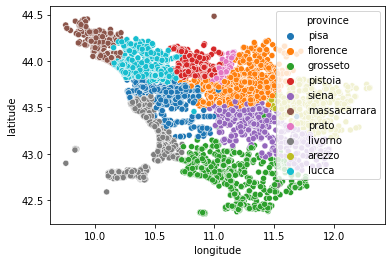

In [4]:
sns.scatterplot(data = df, x='longitude',y='latitude',hue='province')

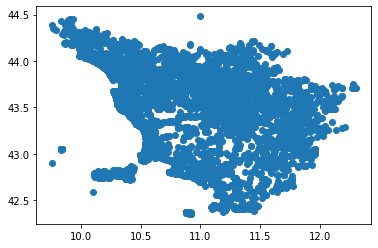

In [7]:
scaler = preprocessing.MinMaxScaler()
#df_clust=pd.DataFrame(scaler.fit_transform(df[['longitude','latitude']]))

df_clust=df[['longitude','latitude']]
from pandas.plotting import scatter_matrix
#scatter_matrix(df_clust, figsize=(10, 10))
plt.scatter(df_clust['longitude'],df_clust['latitude'])
plt.show()

## Crisp Communities

### K means 
Use longitude and latitude

In [8]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(df_clust)
print(pd.Series(kmeans.labels_).value_counts())

3    3452
4    2439
7    1946
1    1615
8    1144
9    1095
2    1060
0    1053
6     751
5     448
dtype: int64


In [9]:
df['kmeans'] = kmeans.labels_.astype(str)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

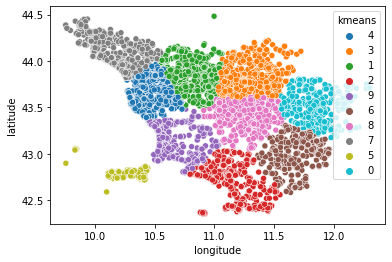

In [10]:
sns.scatterplot(data = df, x='longitude',y='latitude',hue='kmeans')

In [11]:
data = {"communities":[[] for _ in df['kmeans'].unique()]}
for i, c in df['kmeans'].items():
    data['communities'][int(c)].append(i)
    
with open('../data/communities/kmeans.json','w+') as jf:
    json.dump(data, jf)

    


In [12]:
for node in G.nodes:
    G.nodes[node]['kmeans'] = df.loc[node,'kmeans']

### Louvain

In [13]:
louvain = cd.louvain(G, weight='dissimilarity', resolution=1.)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

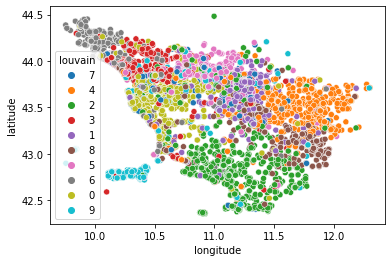

In [14]:
readwrite.write_community_json(louvain,'../data/communities/louvain.json')
assign(G,louvain,'louvain')
for node in G.nodes:
    df.loc[node,'louvain'] = str(G.nodes[node]['louvain'])

sns.scatterplot(data = df[df.louvain.astype(int)<10], x='longitude',y='latitude',hue='louvain')

### greedy modularity

In [15]:
greedy_modularity = cd.greedy_modularity(G, weight='dissimilarity')
readwrite.write_community_json(greedy_modularity,'../data/communities/weighted_greedy_modularity.json')


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

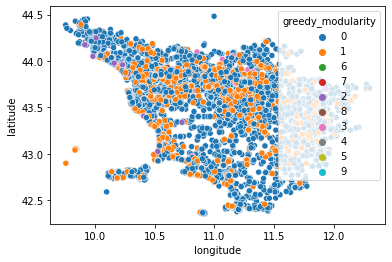

In [16]:
assign(G,greedy_modularity,'greedy_modularity')
for node in G.nodes:
    df.loc[node,'greedy_modularity'] = str(G.nodes[node]['greedy_modularity'])

sns.scatterplot(data = df[df.greedy_modularity.astype(int)<10], x='longitude',y='latitude',hue='greedy_modularity')

In [17]:
for node in list(G.nodes)[:10]: print(G.nodes[node])

{'province': 'pisa', 'kmeans': '4', 'louvain': 7, 'greedy_modularity': 0}
{'province': 'florence', 'kmeans': '3', 'louvain': 7, 'greedy_modularity': 0}
{'province': 'florence', 'kmeans': '3', 'louvain': 7, 'greedy_modularity': 0}
{'province': 'florence', 'kmeans': '3', 'louvain': 7, 'greedy_modularity': 0}
{'province': 'florence', 'kmeans': '3', 'louvain': 7, 'greedy_modularity': 0}
{'province': 'florence', 'kmeans': '3', 'louvain': 7, 'greedy_modularity': 0}
{'province': 'florence', 'kmeans': '1', 'louvain': 7, 'greedy_modularity': 0}
{'province': 'florence', 'kmeans': '3', 'louvain': 7, 'greedy_modularity': 0}
{'province': 'grosseto', 'kmeans': '2', 'louvain': 7, 'greedy_modularity': 0}
{'province': 'pistoia', 'kmeans': '1', 'louvain': 7, 'greedy_modularity': 0}


### Leiden

In [8]:
leiden= cd.leiden(G, weights='dissimilarity')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

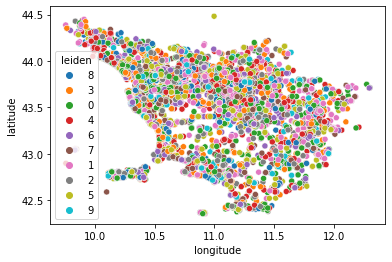

In [10]:
readwrite.write_community_json(leiden,'../data/communities/leiden.json')
assign(G,leiden,'leiden')
for node in G.nodes:
    df.loc[node,'leiden'] = str(G.nodes[node]['leiden'])

sns.scatterplot(data = df[df.leiden.astype(int)<10], x='longitude',y='latitude',hue='leiden')

### Label Propagation

In [41]:
label_propagation = cd.label_propagation(G)
readwrite.write_community_json(label_propagation,'../data/communities/label_propagation.json')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

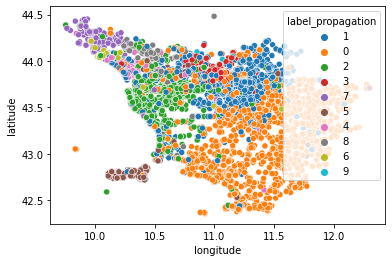

In [46]:

assign(G,label_propagation,'label_propagation')
for node in G.nodes:
    df.loc[node,'label_propagation'] = str(G.nodes[node]['label_propagation'])

sns.scatterplot(data = df[df.label_propagation.astype(int)<10], x='longitude',y='latitude',hue='label_propagation')

### Async Fluid


In [53]:
async_fluid = cd.async_fluid(G,k=5)
readwrite.write_community_json(async_fluid,'../data/communities/async_fluid.json')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

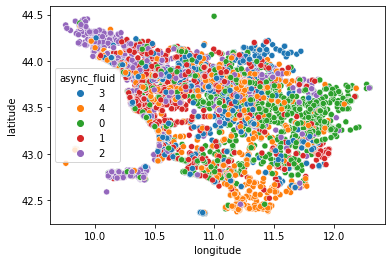

In [54]:
assign(G,async_fluid,'async_fluid')
for node in G.nodes:
    df.loc[node,'async_fluid'] = str(G.nodes[node]['async_fluid'])

sns.scatterplot(data = df[df.async_fluid.astype(int)<10], x='longitude',y='latitude',hue='async_fluid')

## Overlapping Communities

### Angel 

In [27]:
angel = cd.angel(G, min_community_size=7, threshold=0.25)
readwrite.write_community_json(angel,'../data/communities/angel.json')

In [30]:
len(angel.communities)

7

In [30]:
assign(G,angel,'angel',overlap=True)


#sns.scatterplot(data = df[df.greedy_modularity.astype(int)<10], x='longitude',y='latitude',hue='angel')

### Demon

In [33]:
demon = cd.demon(G, min_com_size=10,epsilon=0.25)

readwrite.write_community_json(demon,'../data/communities/demon.json')

## Attribute Comunities
### Eva

In [64]:
df.isnull().sum()

index                   0
position                0
name                    0
city                    2
menu                    0
link                    0
score                 518
N_reviews               0
price                2892
Name                    0
Province                0
City                    0
claimed                 0
covidMeasure            0
travellersChoice        0
latitude                0
longitude               0
cuisines             1337
meals                6281
specialDiets         8389
positionlink            1
province                0
Link                 1752
provinceOK              0
longitud§e          14237
dtype: int64

In [69]:
attributes = ['latitude','longitude']#,'covidMeasure','travellersChoice','claimed','menu','N_reviews']

In [66]:
for node in G.nodes:
    for attr in attributes: 
        G.nodes[node][attr] = df.loc[node,attr]

In [70]:
labels = { node : {attr:G.nodes[node][attr] for attr in attributes} for node in G.nodes()}


In [ ]:
eva = cd.eva(G, labels , weight='dissimilarity')

## Evaluation

In [56]:
G = nx.read_weighted_edgelist('../data/connected.weighted.edgelist')
G = nx.relabel_nodes(G, {node:int(node) for node in G.nodes}) 
df = pd.read_csv('../data/connencted.csv',index_col=0)
#for node in G.nodes:
 #   G.nodes[node]['province'] = df.loc[node,'province']
df.head()

,index,position,name,city,menu,link,score,N_reviews,price,Name,...,latitude,longitude,cuisines,meals,specialDiets,positionlink,province,Link,provinceOK,longitud§e
0,0,2018,Osteria al Borgo,Lucca,False,/Restaurant_Review-g187898-d23137800-Reviews-O...,5.0,6,NaN,Osteria al Borgo,...,43.851808,10.506207,"Pizza, Tuscan, Central-Italian",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",j39_https://maps.google.com/maps?saddr=&daddr=...,pisa,/Restaurant_Review-g187898-d23137800-Reviews-O...,0,10.495633
1,12,1309,Il Genio Italiano,Florence,True,/Restaurant_Review-g187895-d2483611-Reviews-Il...,4.0,229,2.5,Il Genio Italiano,...,43.798058,11.219482,"Italian, Pizza, Mediterranean, Tuscan, Central...",NaN,Vegetarian Friendly,vs1_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2483611-Reviews-Il...,1,NaN
2,37,1316,La Taverna,Scandicci,False,/Restaurant_Review-g644284-d2660933-Reviews-La...,4.0,236,2.5,La Taverna,...,43.764280,11.180183,"Italian, Pizza, Seafood, Mediterranean",NaN,Vegetarian Friendly,zhJ_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g644284-d2660933-Reviews-La...,1,NaN
3,48,1301,Bar Pasticceria Deanna,Florence,False,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,4.0,162,1.0,Bar Pasticceria Deanna,...,43.775550,11.247292,"Italian, Bar, Cafe, Deli",NaN,"Vegetarian Friendly, Vegan Options, Gluten Fre...",hSR_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187895-d2077023-Reviews-Ba...,1,NaN
4,50,1332,Perseus Fiesolano,Fiesole,True,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,3.5,754,2.5,Perseus Fiesolano,...,43.806915,11.293199,"Italian, Mediterranean, Barbecue, Tuscan, Cent...","Lunch, Dinner",Gluten Free Options,d5H_https://maps.google.com/maps?saddr=&daddr=...,florence,/Restaurant_Review-g187896-d2720609-Reviews-Pe...,1,NaN


In [19]:
nx.is_connected(G)

True

In [37]:
import os 
data = dict()


for f in os.listdir('../data/communities'):
    print(f)
    name = f[:-4]
    communities = readwrite.read_community_json(f'../data/communities/{f}')
    data[name] = communities

angel.json
demon.json
leiden.json
louvain.json
weighted_greedy_modularity.json
label_propagation.json
leiden_p.json
rb_pots.json
rber_pots.json
async_fluid_5.json
async_fluid_7.json
kmeans.json


In [38]:
for name, comm in data.items():
    print(name,end= '..  ')
    try: print(evaluation.average_internal_degree(G,comm))
    except Exception as e: print(e) 

angel...  FitnessResult(min=0.0, max=13.925453324378777, score=3.6638633310946944, std=5.926963224402753)
demon...  FitnessResult(min=3.5, max=37.642105263157895, score=9.34513481104347, std=4.855200848313583)
leiden...  FitnessResult(min=0.0, max=3.0023337222870476, score=1.3432813271930342, std=1.0198545873826095)
louvain...  FitnessResult(min=1.6666666666666667, max=30.33613445378151, score=11.036344473525967, std=6.501471604620051)
weighted_greedy_modularity...  FitnessResult(min=1.0, max=30.594594594594593, score=2.990350430357994, std=6.2193727296214965)
label_propagation...  FitnessResult(min=1.0, max=44.35820895522388, score=2.273236398947369, std=4.1940460441599)
leiden_p...  FitnessResult(min=0.0, max=3.7501165501165503, score=1.4376447900224343, std=1.1512122169097416)
rb_pots...  FitnessResult(min=0.0, max=3.5515515515515514, score=1.4589759821665116, std=1.2429510578254854)
rber_pots...  FitnessResult(min=0.0, max=3.7231384307846076, score=1.2862889146812693, std=1.3236890

In [41]:
all_evalution_functions = [evaluation.avg_distance, evaluation.avg_embeddedness, evaluation.average_internal_degree, evaluation.avg_transitivity, evaluation.conductance, evaluation.cut_ratio, evaluation.edges_inside, evaluation.expansion,  evaluation.fraction_over_median_degree,  evaluation.hub_dominance,  evaluation.internal_edge_density, evaluation.normalized_cut, evaluation.max_odf, evaluation.avg_odf, evaluation.flake_odf, evaluation.scaled_density, evaluation.significance, evaluation.size , evaluation.surprise , evaluation.triangle_participation_ratio, evaluation.purity]  

In [42]:
evaluation_functions = [ evaluation.avg_embeddedness, evaluation.average_internal_degree, evaluation.avg_transitivity, evaluation.conductance, evaluation.cut_ratio, evaluation.edges_inside, evaluation.expansion,  evaluation.fraction_over_median_degree,  evaluation.hub_dominance,  evaluation.internal_edge_density, evaluation.normalized_cut, evaluation.max_odf, evaluation.avg_odf, evaluation.flake_odf, evaluation.scaled_density, evaluation.significance, evaluation.size , evaluation.surprise , evaluation.triangle_participation_ratio]  

In [43]:
for evaluation_function in evaluation_functions:
    print(str(evaluation_function).split(' ')[1].upper())
    for name, comm in data.items():
        print(name,end= '..  ')
        try: print(evaluation_function(G,comm))
        except Exception as e: print(e) 
    print('\n\n')

AVG_EMBEDDEDNESS
angel...  

KeyboardInterrupt: 

In [36]:
all_modularities = [evaluation.erdos_renyi_modularity, evaluation.link_modularity , evaluation.modularity_density , evaluation.newman_girvan_modularity , evaluation.z_modularity]

In [38]:
for modularity in all_modularities:
    print(str(modularity).split(' ')[1].upper())
    for name, comm in data.items():
        print(name,end= '..  ')
        try: print(modularity(G,comm))
        except Exception as e: print(e) 
    print('\n\n')

ERDOS_RENYI_MODULARITY
angel...  FitnessResult(min=None, max=None, score=0.09941796570606466, std=None)
demon...  FitnessResult(min=None, max=None, score=1.8573629934778455, std=None)
leiden...  FitnessResult(min=None, max=None, score=0.03523570100718018, std=None)
louvain...  FitnessResult(min=None, max=None, score=0.5548396033859107, std=None)
weighted_greedy_modularity...  FitnessResult(min=None, max=None, score=0.32556394338533595, std=None)



LINK_MODULARITY
angel...  Unable to allocate 482. MiB for an array with shape (7950, 7950) and data type float64
demon...  FitnessResult(min=None, max=None, score=0.07672889590428864, std=None)
leiden...  FitnessResult(min=None, max=None, score=0.017278069979791612, std=None)
louvain...  FitnessResult(min=None, max=None, score=0.09311271614323627, std=None)
weighted_greedy_modularity...  Unable to allocate 1.01 GiB for an array with shape (11628, 11628) and data type float64



MODULARITY_DENSITY
angel...  FitnessResult(min=None, max=None, s

In [4]:
viz.plot_com_stat([comms for comms in data.values()], evaluation.size)

ModuleNotFoundError: Optional dependency not satisfied: install igraph to use the selected feature.